In [31]:
import numpy as np
import simpy
import random
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.lib.function_base import average
from numpy.lib.polynomial import poly1d

In [76]:
# Parameters
ROH = 0.8 # Utilization factor
MU = 1/10 # Average service rate (customers per time unit)
LAMBDA = ROH*MU  # Average arrival rate (customers per time unit)
SIM_TIME = 10000  # Simulation time in number of time units

times_in_system = []  # List to record time spent in system for each customer
num_customers_in_system = []  # Number of customers in the system at regular intervals



In [39]:
# calculation of expected values

a = 1/(ROH*MU)
lq = ROH**2/(1-ROH)
ls = ROH/(1-ROH)
wq = ROH**2/(ROH*MU*(1-ROH))
ws = ROH/(ROH*MU*(1-ROH))

p0 = 1-ROH**2
p1 = ROH**2*0.2
p2 = ROH**3*0.2
p = p0+p1+p2

print("ROH:", ROH)
print("MU:", MU)
print("a:", a)
print("ls:", ls)
print("lq:", lq)
print("wq:", wq)
print("ws:", ws)
print("p:", p)


ROH: 0.8
MU: 0.1
a: 12.499999999999998
ls: 4.000000000000001
lq: 3.2000000000000015
wq: 40.00000000000001
ws: 50.0
p: 0.5903999999999999


In [15]:
# simulation processes
def customer(env, name, server):
    """Customer process. Customers arrive and get served."""
    arrival_time = env.now

    # Request a server
    with server.request() as req:
        yield req

        # Server is available, start service
        service_time = random.expovariate(MU)
        yield env.timeout(service_time)
        
        # Record the time spent in the system
        times_in_system.append(env.now - arrival_time)

def source(env, server):
    """Generate new customers."""
    i = 0
    while True:
        yield env.timeout(random.expovariate(LAMBDA)) # Generate new customers at random times
        i += 1
        env.process(customer(env, f"Customer-{i}", server))

def monitor(env, server, interval=1):
    """Monitor the number of customers in the system at regular intervals."""
    while True:
        num_customers_in_system.append(len(server.queue) + server.count)  # server.count is the number of customers currently being served
        yield env.timeout(interval)

In [77]:
# Setup and start the simulation
random.seed(42)
env = simpy.Environment()
server = simpy.Resource(env, capacity=1)

# Start initial processes
env.process(source(env, server))
env.process(monitor(env, server))
env.run(until=SIM_TIME)

count = 0
print(f"Time in System{count}: {np.quantile(times_in_system, 0.9)}")
print(f"MU{count}: ", MU)

# Adjust MU and rerun the simulation until the condition is met
while np.quantile(times_in_system, 0.9) > 60:
    count += 1
    MU += 0.05
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(source(env, server))
    env.process(monitor(env, server))
    env.run(until=SIM_TIME)
    print(f"Time in System{count}: {np.quantile(times_in_system, 0.9)}")
    print(f"MU{count}: ", MU)



Time in System0: 159.91170256227906
MU0:  0.1
Time in System1: 101.87027488793721
MU1:  0.15000000000000002
Time in System2: 71.32359363118293
MU2:  0.2
Time in System3: 50.04210481021755
MU3:  0.25


In [ ]:
# Setup and start the simulation
random.seed(42)
env = simpy.Environment()

# Start processes and run
server = simpy.Resource(env, capacity=1)
env.process(source(env, server))
env.process(monitor(env, server))
env.run(until=SIM_TIME)

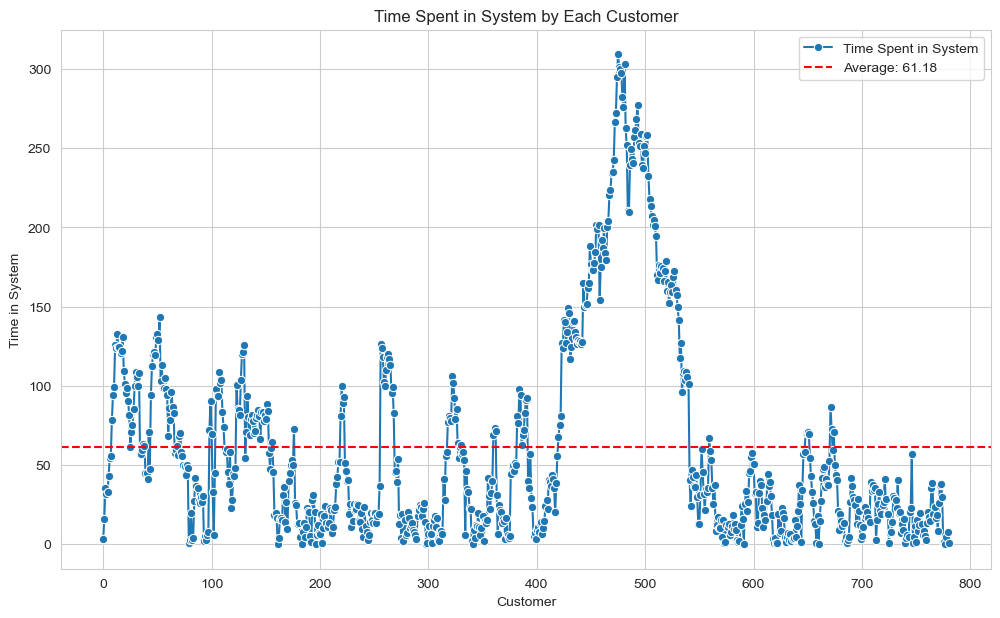

In [17]:
# Set the Seaborn style
sns.set_style("whitegrid")

# Compute the average time in system
avg_time = sum(times_in_system) / len(times_in_system)

# Plotting the times in system
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(times_in_system)), y=times_in_system, marker='o', linestyle='-', label='Time Spent in System')
plt.axhline(avg_time, color='red', linestyle='--', label=f'Average: {avg_time:.2f}')
plt.title("Time Spent in System by Each Customer")
plt.xlabel("Customer")
plt.ylabel("Time in System")
plt.legend()
plt.show()

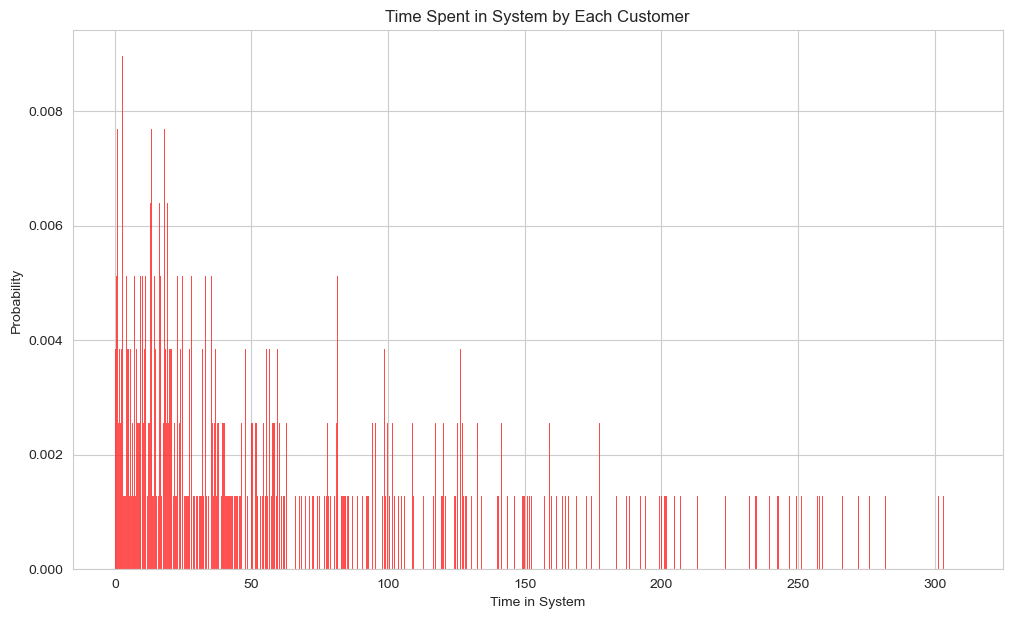

In [20]:
# create a histogram of the time spent in the system use 0.2 as the bin size
plt.figure(figsize=(12, 7))
sns.histplot(x=times_in_system, binwidth=0.2, stat="probability", color='red')
plt.title("Time Spent in System by Each Customer")
plt.xlabel("Time in System")
plt.ylabel("Probability")
plt.show()


In [22]:
# compare expected and simulated average time in system
print("simulated average time in system: {}".format(avg_time))
print("calculated average time in system: {}".format(ws))

simulated average time in system: 61.18395243108528
calculated average time in system: 50.0


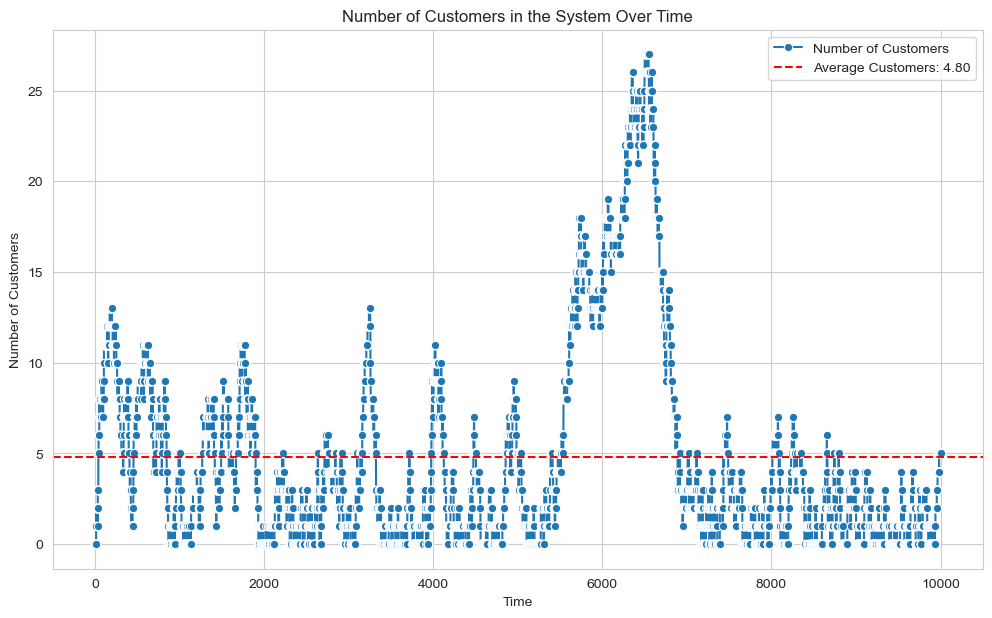

In [23]:
# Plotting the number of customers in the system
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(num_customers_in_system)), y=num_customers_in_system, marker='o', linestyle='-', label='Number of Customers')
avg_customers = sum(num_customers_in_system) / len(num_customers_in_system)
plt.axhline(avg_customers, color='red', linestyle='--', label=f'Average Customers: {avg_customers:.2f}')
plt.title("Number of Customers in the System Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()

In [27]:
# compare simulated and expected average number of customers in the system
print("simulated average customers in system: {}".format(avg_customers))
print("calculated average customers in system: {}".format(ls))

simulated average customers in system: 4.7997
calculated average customers in system: 4.000000000000001


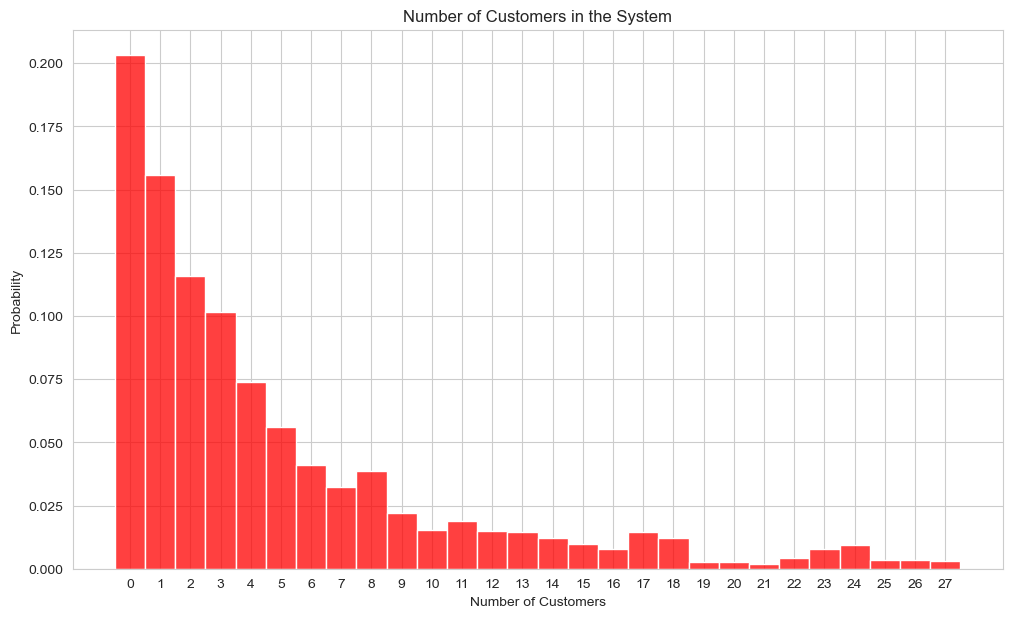

In [28]:
# histogram of numof customers in the system, x-axis ticks should be each integer
plt.figure(figsize=(12, 7))
sns.histplot(x=num_customers_in_system, stat="probability", color='red', discrete=True)
plt.title("Number of Customers in the System")
plt.xlabel("Number of Customers")
plt.ylabel("Probability")
plt.xticks(range(max(num_customers_in_system)+1))
plt.show()
